In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Step 1: Load and preprocess the dataset



# Load the dataset
df = pd.read_excel('retail_store_inventory.xlsx')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter data based on year 2023
filtered_df = df[df['Date'].dt.year == 2023]

# Drop rows with missing values in critical columns
filtered_df = filtered_df.dropna(subset=['Inventory Level', 'Units Sold', 'Demand Forecast', 'Price', 'Discount'])

# Extract relevant columns for optimization
relevant_columns = ['Store ID', 'Product ID', 'Category', 'Region', 'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast']

# Subset the dataset
data = filtered_df[relevant_columns].copy()

# Group data by 'Store ID' and 'Product ID' to prepare for inventory optimization
grouped_data = data.groupby(['Store ID', 'Product ID']).agg({
    'Inventory Level': 'mean',  # Average inventory level
    'Units Sold': 'sum',        # Total units sold
    'Demand Forecast': 'mean'   # Average demand forecast
}).reset_index()

# Calculate dynamic max inventory for each product based on its demand forecast
def calculate_dynamic_max_inventory(demand_forecast, demand_scaling_factor=2):
    """
    Function to calculate max inventory based on demand.
    - demand_scaling_factor adjusts how much inventory is allocated relative to demand.
    """
    return int(demand_forecast * demand_scaling_factor)

# Apply the dynamic max inventory to each product
grouped_data['Max Inventory'] = grouped_data['Demand Forecast'].apply(calculate_dynamic_max_inventory)

# Step 2: Restocking Logic

# Calculate restocking threshold based on  demand
def calculate_restocking_threshold(demand, safety_stock=10):
    """
    Function to calculate restocking threshold for inventory.
    - demand is the predicted demand.
    - safety_stock is a buffer stock to avoid stockouts.
    """
    return int(demand * 0.5) + safety_stock  # 50% of demand + safety stock

# Calculate restocking threshold and target inventory for each product
grouped_data['Restocking Threshold'] = grouped_data['Demand Forecast'].apply(calculate_restocking_threshold)

# Calculate target inventory (can be dynamic based on demand)
def calculate_target_inventory(demand, max_inventory):
    """
    Function to calculate target inventory based on demand and max inventory.
    - demand is the demand.
    - max_inventory is the maximum inventory based on demand forecast.
    """
    return min(max_inventory, demand * 1.5)  # Target inventory is 1.5 times demand

grouped_data['Target Inventory'] = grouped_data.apply(lambda row: calculate_target_inventory(
    row['Demand Forecast'], row['Max Inventory']), axis=1)

# Calculate how much to restock (difference between target inventory and current inventory)
grouped_data['Restock Quantity'] = grouped_data['Target Inventory'] - grouped_data['Inventory Level']
grouped_data['Restock Quantity'] = grouped_data['Restock Quantity'].apply(lambda x: max(x, 0))  # No negative restocking

# Step 3: Tabu Search Algorithm

# Objective function: Total cost (holding cost + stockout penalty + restocking cost)
def calculate_total_cost(inventory, demand, holding_costs, stockout_penalties, restock_quantities):
    total_cost = 0
    for i in range(len(inventory)):
        # Holding cost is incurred when inventory exceeds demand
        holding_cost = holding_costs[i] * max(0, inventory[i] - demand[i])
        # Stockout penalty is incurred when demand exceeds inventory
        stockout_penalty = stockout_penalties[i] * max(0, demand[i] - inventory[i])
        # Restocking cost (could be added as a penalty for frequent restocking)
        restocking_cost = restock_quantities[i] * 0.5  # Assuming a constant restocking cost per unit
        total_cost += holding_cost + stockout_penalty + restocking_cost
    return total_cost

# Generate initial solution (random inventory levels based on max inventory per product)
def generate_initial_solution(num_products, max_inventories):
    return [random.randint(0, max_inventories[i]) for i in range(num_products)]

# Generate neighbors (small adjustments to inventory levels based on max inventory for each product)
def generate_neighbors(solution, max_inventories, max_move_size):
    neighbors = []
    for i in range(len(solution)):
        new_solution = solution.copy()
        move_size = random.randint(1, max_move_size)
        direction = random.choice([-1, 1])  # Decrease or increase inventory
        new_solution[i] = max(0, min(max_inventories[i], solution[i] + direction * move_size))
        neighbors.append(new_solution)
    return neighbors

# Tabu Search algorithm with dynamic max inventory for each product
def tabu_search(num_products, demand, holding_costs, stockout_penalties, max_inventories, restock_quantities, max_move_size, max_iterations, tabu_tenure, patience=50):
    """
    Performs the Tabu Search to minimize the total cost (holding cost + stockout penalty + restocking cost).
    
    Args:
    - num_products: Number of products (data points).
    - demand: List/array of demand values for each product.
    - holding_costs: List/array of holding costs for each product.
    - stockout_penalties: List/array of stockout penalties for each product.
    - max_inventories: List/array of max inventory levels for each product.
    - restock_quantities: List/array of restock quantities for each product.
    - max_move_size: Maximum change in inventory for each move.
    - max_iterations: Maximum number of iterations to run the search.
    - tabu_tenure: The number of iterations a move is forbidden after it is made (size of the tabu list).
    - patience: The number of iterations without improvement before stopping the search.

    Returns:
    - best_solution: The best inventory solution found.
    - best_cost: The total cost associated with the best solution.
    """
    # Initialize parameters
    current_solution = generate_initial_solution(num_products, max_inventories)
    best_solution = current_solution
    best_cost = calculate_total_cost(current_solution, demand, holding_costs, stockout_penalties, restock_quantities)
    
    tabu_list = []
    iteration = 0
    no_improvement_counter = 0  # Counter to track if no improvement is found
    
    while iteration < max_iterations and no_improvement_counter < patience:
        # Generate neighbors
        neighbors = generate_neighbors(current_solution, max_inventories, max_move_size)
        best_neighbor = None
        best_neighbor_cost = float('inf')
        
        # Evaluate neighbors
        for neighbor in neighbors:
            if neighbor not in tabu_list:
                neighbor_cost = calculate_total_cost(neighbor, demand, holding_costs, stockout_penalties, restock_quantities)
                if neighbor_cost < best_neighbor_cost:
                    best_neighbor_cost = neighbor_cost
                    best_neighbor = neighbor
        
        # If a better solution is found, update
        if best_neighbor_cost < best_cost:
            best_solution = best_neighbor
            best_cost = best_neighbor_cost
            no_improvement_counter = 0  # Reset improvement counter because we found a better solution
        else:
            no_improvement_counter += 1  # No improvement found, increment the counter
        
        # Update the tabu list
        tabu_list.append(current_solution)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
        
        # Move to the best neighbor
        current_solution = best_neighbor
        iteration += 1
    
    return best_solution, best_cost

# Example Usage (with patience to stop when no improvement is found)

# Number of products (rows) in the dataset
num_products = len(grouped_data)

# Parameters for Tabu Search
max_move_size = 20  # Maximum inventory change in one move
max_iterations = 10000  # Maximum number of iterations
tabu_tenure = 30  # Tabu list size
patience = 10  # Number of iterations without improvement before stopping

# Example data (demand, holding costs, and stockout penalties for each product)
demand = grouped_data['Demand Forecast'].values  # demand based on forecast
holding_costs = np.random.uniform(0.5, 2.0, size=num_products)  # Random holding costs
stockout_penalties = np.random.uniform(5.0, 10.0, size=num_products)  # Random stockout penalties
max_inventories = grouped_data['Max Inventory'].values  # Dynamic max inventory based on demand
restock_quantities = grouped_data['Restock Quantity'].values  # How much to restock based on target inventory

# Run the Tabu Search
best_solution, best_cost = tabu_search(num_products, demand, holding_costs, stockout_penalties, max_inventories, restock_quantities, max_move_size, max_iterations, tabu_tenure, patience)

# Step 4: Add the 'Best Solution Inventory' and 'Total Cost' to the DataFrame
grouped_data['Best Solution Inventory'] = best_solution

# Calculate total cost for each product based on best solution
grouped_data['Total Cost'] = grouped_data.apply(lambda row: calculate_total_cost(
    [row['Best Solution Inventory']], [row['Demand Forecast']], [row['Max Inventory']], [row['Restocking Threshold']], [row['Restock Quantity']]), axis=1)

# Step 5: Display the results table with tabulate

# Format the results table for better readability
grouped_data['Inventory Level'] = grouped_data['Inventory Level'].round(2)
grouped_data['Demand Forecast'] = grouped_data['Demand Forecast'].round(2)
grouped_data['Restocking Threshold'] = grouped_data['Restocking Threshold'].round(2)
grouped_data['Target Inventory'] = grouped_data['Target Inventory'].round(2)
grouped_data['Restock Quantity'] = grouped_data['Restock Quantity'].round(2)
grouped_data['Best Solution Inventory'] = grouped_data['Best Solution Inventory'].round(2)
grouped_data['Total Cost'] = grouped_data['Total Cost'].round(2)

# Display the results as a nicely formatted table using tabulate
results_table = grouped_data[['Store ID', 'Product ID', 'Inventory Level', 'Demand Forecast', 
                              'Restocking Threshold', 'Target Inventory', 'Restock Quantity', 
                              'Best Solution Inventory', 'Total Cost']]

# Create a tabulated string
table_output = tabulate(results_table, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(table_output)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

+----------+------------+-----------------+------------+-----------------+----------------------+------------------+-------------------------+------------+
| Store ID | Product ID | Inventory Level | Units Sold | Demand Forecast | Restocking Threshold | Restock Quantity | Best Solution Inventory | Total Cost |
+----------+------------+-----------------+------------+-----------------+----------------------+------------------+-------------------------+------------+
|   S001   |   P0001    |     274.85      |   136.43   |     136.43      |          78          |      108.36      |           480           |   397.75   |
|   S001   |   P0002    |     267.09      |   117.96   |      127.2      |          68          |      113.14      |           21            |   153.53   |
|   S001   |   P0003    |      280.5      |   144.66   |     133.02      |          82          |      115.94      |           198           |   111.31   |
|   S001   |   P0004    |     267.82      |   142.33   |     134

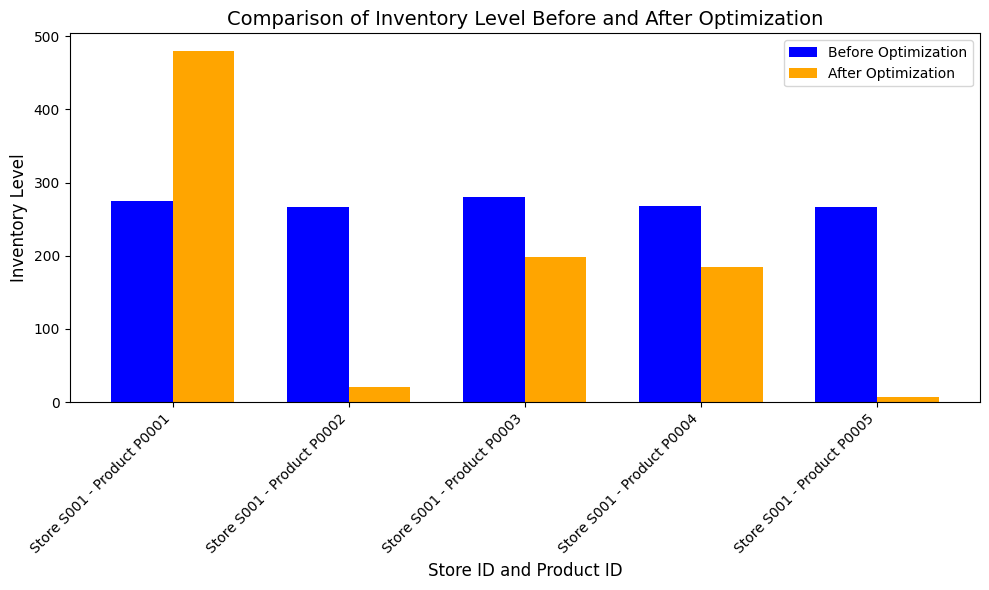

In [24]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ================================
# Step 1: Load and Preprocess Data
# ================================

def load_and_preprocess_data(file_path):
    # Load the dataset
    df = pd.read_excel(file_path)

    # Convert 'Date' column to datetime and filter for the year 2023
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df_2023 = df[df['Date'].dt.year == 2023]

    # Drop rows with missing values in critical columns
    df_2023 = df_2023.dropna(subset=['Inventory Level', 'Units Sold', 'Units Ordered'])

    # Extract relevant columns for optimization
    relevant_columns = ['Store ID', 'Product ID', 'Inventory Level', 'Units Sold', 'Units Ordered']
    return df_2023[relevant_columns]

# ================================
# Step 2: Calculate Inventory Metrics with Demand Forecast
# ================================

def calculate_restocking_threshold(units_sold, safety_stock=10):
    """
    Calculate restocking threshold based on units sold.
    Restocking Threshold = 50% of units sold + safety stock
    """
    return int(units_sold * 0.5) + safety_stock

def calculate_demand_forecast(df, window_size=3):
    """
    Calculate demand forecast using a rolling average of historical units sold.
    The rolling average smoothens fluctuations and provides a better estimate of future demand.
    """
    df['Demand Forecast'] = df['Units Sold'].rolling(window=window_size, min_periods=1).mean()
    return df

def preprocess_inventory_data(df):
    # Group data by Store ID and Product ID and calculate average values
    grouped_data = df.groupby(['Store ID', 'Product ID']).agg({
        'Inventory Level': 'mean',
        'Units Sold': 'mean',
        'Units Ordered': 'mean',
    }).reset_index()

    # Calculate demand forecast using a rolling average
    grouped_data = calculate_demand_forecast(grouped_data)

    # Calculate restocking threshold for each product
    grouped_data['Restocking Threshold'] = grouped_data['Units Sold'].apply(calculate_restocking_threshold)

    # Use 'Units Ordered' directly for restocking quantity
    grouped_data['Restock Quantity'] = grouped_data['Units Ordered']

    return grouped_data


# ================================
# Step 3: Tabu Search Optimization
# ================================

def calculate_total_cost(inventory, units_sold, holding_costs, stockout_penalties, restock_quantities):
    total_cost = 0
    num_elements = len(inventory)
    
    for i in range(num_elements):
        holding_cost = holding_costs[i] * max(0, inventory[i] - units_sold[i])
        stockout_penalty = stockout_penalties[i] * max(0, units_sold[i] - inventory[i])
        restocking_cost = restock_quantities[i] * 0.5  # Assuming restocking cost per unit is 0.5
        total_cost += holding_cost + stockout_penalty + restocking_cost
    return total_cost


def generate_initial_solution(num_stores, num_products):
    # Generate a random initial solution for inventory levels for each store-product combination
    return np.random.randint(1,200 , size=(num_stores, num_products))  # Random inventory levels for each store-product


def generate_neighbors(solution, max_move_size):
    neighbors = []
    solution = solution.reshape(-1)
    for i in range(len(solution)):
        new_solution = solution.copy()
        move_size = random.randint(1, max_move_size)
        direction = random.choice([-1, 1])  # Decrease or increase inventory
        new_solution[i] = max(0, solution[i] + direction * move_size)
        neighbors.append(new_solution)
    return neighbors


def tabu_search(num_stores, num_products, units_sold, holding_costs, stockout_penalties, restock_quantities,
                max_move_size, max_iterations, tabu_tenure, patience=50):
    """
    Tabu Search optimization to minimize inventory costs considering each store-product combination.
    """
    current_solution = generate_initial_solution(num_stores, num_products)
    best_solution = current_solution
    best_cost = calculate_total_cost(current_solution.flatten(), units_sold.flatten(), holding_costs.flatten(),
                                     stockout_penalties.flatten(), restock_quantities.flatten())

    tabu_list = []
    no_improvement_counter = 0
    iteration = 0

    while iteration < max_iterations and no_improvement_counter < patience:
        # Generate neighbors of the current solution
        neighbors = generate_neighbors(current_solution.flatten(), max_move_size)
        best_neighbor, best_neighbor_cost = None, float('inf')

        for neighbor in neighbors:
            if neighbor.tolist() not in tabu_list:
                neighbor_cost = calculate_total_cost(neighbor, units_sold.flatten(), holding_costs.flatten(),
                                                     stockout_penalties.flatten(), restock_quantities.flatten())
                if neighbor_cost < best_neighbor_cost:
                    best_neighbor_cost = neighbor_cost
                    best_neighbor = neighbor.tolist()

        # Update best solution if a better neighbor is found
        if best_neighbor_cost < best_cost:
            best_solution = np.array(best_neighbor).reshape(num_stores, num_products)
            best_cost = best_neighbor_cost
            no_improvement_counter = 0  # Reset counter
        else:
            no_improvement_counter += 1  # Increment counter if no improvement

        # Update tabu list and move to the best neighbor
        tabu_list.append(current_solution.tolist())
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        current_solution = best_solution
        iteration += 1

    return best_solution, best_cost


# ================================
# Step 4: Display Results
# ================================

def display_results(grouped_data, best_solution):
    # Reshape best_solution to match the number of rows in grouped_data
    best_solution_flat = best_solution.flatten()

    # Ensure the length of best_solution matches the length of grouped_data
    if len(best_solution_flat) != len(grouped_data):
        raise ValueError(f"Length mismatch: best_solution has {len(best_solution_flat)} values, "
                         f"but grouped_data has {len(grouped_data)} rows.")

    # Assign best solution inventory levels to grouped_data
    grouped_data['Best Solution Inventory'] = best_solution_flat

    # Calculate total cost for each product based on best solution
    grouped_data['Total Cost'] = grouped_data.apply(
        lambda row: calculate_total_cost([row['Best Solution Inventory']], [row['Units Sold']],
                                         [1.0], [1.0], [row['Restock Quantity']]),
        axis=1)

    # Format the results for readability
    grouped_data = grouped_data.round({'Inventory Level': 2, 'Units Sold': 2, 'Demand Forecast': 2,
                                       'Restocking Threshold': 2, 'Restock Quantity': 2,
                                       'Best Solution Inventory': 2, 'Total Cost': 2})

    # Create the result table for display
    results_table = grouped_data[['Store ID', 'Product ID', 'Inventory Level', 'Units Sold', 'Demand Forecast',
                                  'Restocking Threshold', 'Restock Quantity', 'Best Solution Inventory', 'Total Cost']]

    # Print the results table using tabulate for better readability
    print(tabulate(results_table, headers='keys', tablefmt='pretty', showindex=False))


def plot_comparison_graph(grouped_data):
    """
    Plot a bar chart comparing the Inventory Level before and after optimization.
    """
    # Select a subset of data to visualize (e.g., for the first 5 store-product combinations)
    subset_data = grouped_data.head(5)

    # Create a new DataFrame to compare before and after optimization
    comparison_df = subset_data[['Store ID', 'Product ID', 'Inventory Level', 'Best Solution Inventory']]

    # Set the position of the bars
    bar_width = 0.35
    index = np.arange(len(comparison_df))

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot before optimization (Inventory Level)
    ax.bar(index, comparison_df['Inventory Level'], bar_width, label='Before Optimization', color='blue')

    # Plot after optimization (Best Solution Inventory)
    ax.bar(index + bar_width, comparison_df['Best Solution Inventory'], bar_width, label='After Optimization', color='orange')

    # Set the labels and title
    ax.set_xlabel('Store ID and Product ID', fontsize=12)
    ax.set_ylabel('Inventory Level', fontsize=12)
    ax.set_title('Comparison of Inventory Level Before and After Optimization', fontsize=14)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f"Store {row['Store ID']} - Product {row['Product ID']}" for _, row in comparison_df.iterrows()], rotation=45, ha="right")

    # Add a legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# ================================
# Main Function: Putting it all together
# ================================

def main():
    # File path to the dataset
    file_path = 'retail_store_inventory.xlsx'

    # Load and preprocess the data
    df = load_and_preprocess_data(file_path)

    # Group data by Store ID and Product ID and calculate average values
    grouped_data = preprocess_inventory_data(df)

    # Tabu search parameters
    max_move_size = 20  # Maximum inventory change in one move
    max_iterations = 1000  # Maximum number of iterations
    tabu_tenure = 30  # Tabu list size
    patience = 10  # Number of iterations without improvement before stopping

    # Number of stores and products
    num_stores = len(df['Store ID'].unique())
    num_products = len(df['Product ID'].unique())

    # Get the data needed for the optimization
    units_sold = df.pivot_table(index='Store ID', columns='Product ID', values='Units Sold', aggfunc='sum').values
    holding_costs = np.random.uniform(0.5, 2.0, size=(num_stores, num_products))
    stockout_penalties = np.random.uniform(5.0, 10.0, size=(num_stores, num_products))
    restock_quantities = df.pivot_table(index='Store ID', columns='Product ID', values='Units Ordered', aggfunc='sum').values

    # Run Tabu Search optimization
    best_solution, best_cost = tabu_search(num_stores, num_products, units_sold, holding_costs,
                                           stockout_penalties, restock_quantities, max_move_size,
                                           max_iterations, tabu_tenure, patience)

    # Display the final results
    display_results(grouped_data, best_solution)
    
    # Plot comparison graph for inventory levels before and after optimization
    plot_comparison_graph(grouped_data)
    




if __name__ == "__main__":
    main()
